<a href="https://colab.research.google.com/github/chetansolanke14/machine_learning/blob/master/Week_11_Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

In this experiment we will see the Auto Encoder neural network.

In this experiment we will be using MNIST database. The MNIST database is a dataset of handwritten digits. It has 60,000 training samples, and 10,000 test samples. Each image is represented by 28 x 28 pixels, each containing a value 0 - 255 with its gray scale value.

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

**Auto Encoders** are a specific type of feedforward neural networks where the input is the same as the output. They compress the input into a lower-dimensional code and then reconstruct the output from this representation.

### Keywords

* Autoencoders
* Dimensionality reduction
* Reconstruction
* PCA
* MSEloss

### Expected time to complete the experiment is : 60min

In [1]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="800" height="300" controls>
  <source src="https://cdn.talentsprint.com/talentsprint/archives/sc/aiml/aiml_2018_blr_b6/cfus/week_11/module_3_week_11_experiment_1.mp4" type="video/mp4">
</video>
""")

### Setup Steps

In [0]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "P181901451" #@param {type:"string"}


In [0]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "9822140781" #@param {type:"string"}


In [3]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="BLR_M3W11_SAT_EXP_1" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
   ipython.magic("sx pip3 install torch")
   ipython.magic("sx pip3 install torchvision")
   ipython.magic("sx pip install Pillow==4.0.0")
   print ("Setup completed successfully")
   return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "id" : Id, "file_hash" : file_hash, "notebook" : notebook}

      r = requests.post(url, data = data)
      print("Your submission is successful.")
      print("Ref Id:", submission_id)
      print("Date of submission: ", datetime.datetime.now().date().strftime("%d %b %Y"))
      print("Time of submission: ", datetime.datetime.now().time().strftime("%H:%M:%S"))
      print("View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions")
      print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
  
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


#### Loading the required packages

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision.datasets as dsets
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### Defining the parameters

In [0]:
EPOCH = 10
batch_size = 64
LR = 0.005      
DOWNLOAD_MNIST = False
### Number of images we want to test on
N_TEST_IMG = 10

#### Loading MNIST dataset from torchvision datasets

In [0]:
#Loading the train set file
train_data = dsets.MNIST(root='../data', 
                            train=True, 
                            transform=transforms.ToTensor(),  
                            download=True)
#Loading the test set file
test_data = dsets.MNIST(root='../data', 
                           train=False, 
                           transform=transforms.ToTensor())

#### Visulaizing one of the training data

torch.Size([60000, 28, 28])
torch.Size([60000])


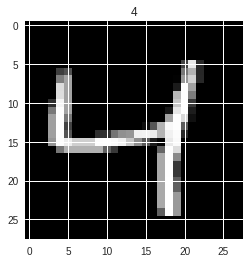

In [28]:
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [0]:
#loading the train dataset
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# loading the test dataset

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True)

#### Now let us construct the autoencoder neural network

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            # activation functions
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            #activation functions
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

#### Now let us plot the original image and decoded image. First plot is original image and second plot is decoded image. We will also calculate the training loss for every epoch in steps. 

In [16]:
autoencoder = AutoEncoder()
print(autoencoder)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [19]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)


In [20]:
loss_func = nn.MSELoss()
print(loss_func)

MSELoss()


In [31]:
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
print(view_data,view_data.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) torch.Size([10, 784])


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)
Epoch:  0 | train loss: 0.2313


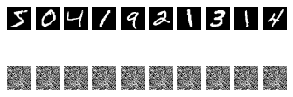

Epoch:  0 | train loss: 0.0512


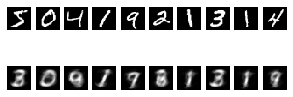

Epoch:  5 | train loss: 0.0375


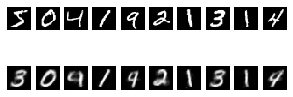

Epoch:  5 | train loss: 0.0339


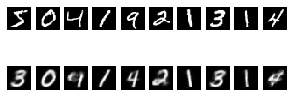

Epoch:  9 | train loss: 0.0299


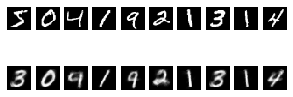

Epoch:  9 | train loss: 0.0352


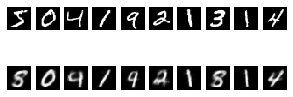

In [32]:
autoencoder = AutoEncoder()
print(autoencoder)

# Initialization of Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
## Initialization of Mean Square Error
loss_func = nn.MSELoss()

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)
        b_label = y               # batch label

        encoded, decoded = autoencoder(b_x)
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())
            # plotting decoded image (second row)
            encoded_data, decoded_data = autoencoder(view_data)
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            #Plotting orginal images
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
            # Plotting the decoded images
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); 

Applying Autoencoders on the test data and finding the loss on the test dataset

In [33]:
# Initialization of Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
## Initialization of Mean Square Error
loss_func = nn.MSELoss()

# original data (first row) for viewing
view_data = test_data.test_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.

for b_x in range(EPOCH):
    for step, (x, y) in enumerate(test_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)
        b_label = y               # batch label

        encoded, decoded = autoencoder(b_x)
        loss = loss_func(decoded, b_y)
print(loss)

tensor(0.0342, grad_fn=<MseLossBackward>)


In previous experiments we have used PCA technique for dimensionality reduction which is restricted to linear map while auto encoders can have nonlinear enoder/decoders.

Applying PCA Reconstruction on the test data and calculating the loss.we can see that the autoencoders are more compact than PCA.

In [34]:
from sklearn.decomposition import PCA
import numpy as np
# Reconstruct original data
# Perform PCA for three components
pca = PCA(3)
loss = 0
for step, (x, y) in enumerate(test_loader):
        b_x = (x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = (x.view(-1, 28*28))
        b_x = np.array(b_x)
        b_y = np.array(b_y)
        data_reduced = pca.fit_transform(b_x)
        data_reconstructed = pca.inverse_transform(data_reduced)
        #loss += ((abs(data_reconstructed) - (b_x)) ** 2)
        loss += ((b_x - data_reconstructed) ** 2).mean()
print(loss)

7.347914569079876


From above we can observe that pca loss is greater thab autoencoder loss attributed to the non-linearty reduction.

### Please answer the questions below to complete the experiment:




In [0]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging me" #@param ["Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging me", "Was Tough, but I did it", "Too Difficult for me"]


In [0]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "NA" #@param {type:"string"}

In [0]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["Yes", "No"]

In [39]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 9721
Date of submission:  02 Feb 2019
Time of submission:  09:42:57
View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions
For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.
